# **Lab 4.1 Data Augmentation with PyTorch**

In [1]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset
from torch.nn import functional as F
import random
import cv2
import numpy as np
from skimage.util import random_noise
import matplotlib.pyplot as plt
import os

Complete the `load_data()` function that loads the image using `ImageFolder()` with the specific `transforms.compose()` provided below.
`load_data()` will return DataLoader() and print the information about the Dataset.

`transforms.Compose()` :
- `transforms.Resize()`
- `transforms.ToTensor()`
- `transforms.Pad()`
- `transforms.RandomAffine(degrees=45, translate=(0.1, 0.1),scale=(0.8, 1.2), shear=45)`
- `transforms.CenterCrop()`

Resource : [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html#compose), [`torchvision.transforms v1`](<https://pytorch.org/vision/stable/transforms.html#v1-api-reference:~:text=custom)%20tv_tensor%20type.-,V1%20API%20Reference,-Geometry>), [`ImageFolder`](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html), [`Dataloader`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#:~:text=Preparing%20your%20data%20for%20training%20with%20DataLoaders)

In [2]:
def load_data(path):
    ### START CODE HERE ###
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Pad(10),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
        transforms.CenterCrop((224, 224)),
    ])

    dataset = ImageFolder(path, transform=transform)


    data_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=16, pin_memory=True)

    return data_loader
    ### END CODE HERE ###

Use your load_data() function to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
📃Train Dataset:
	Number of images in class battleship: 44
	Number of images in class patrol boat: 35
	Number of images in class submarine: 35
	Number of samples: 114
```


![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/01.png?raw=true)

</details>

c:\Users\NITRO\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


torch.Size([16, 3, 224, 224]) torch.Size([16])


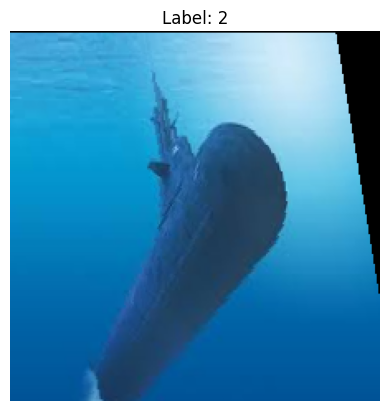

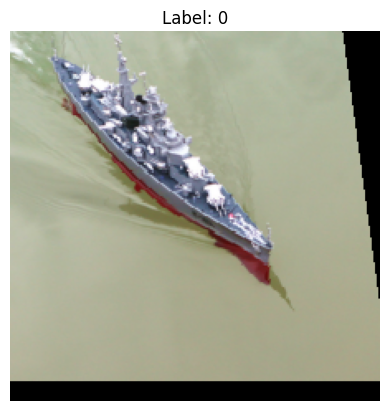

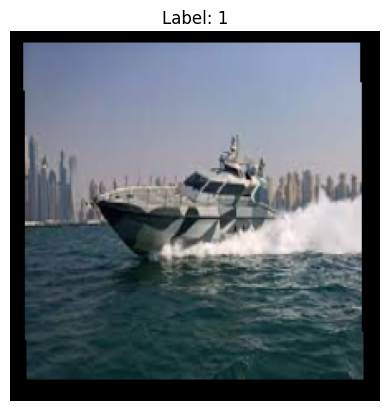

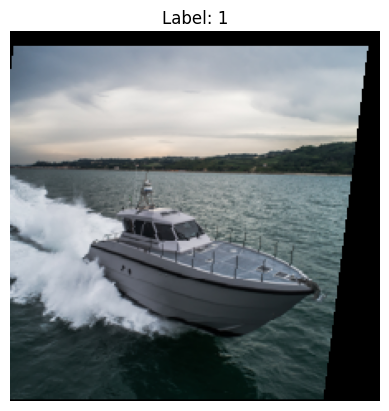

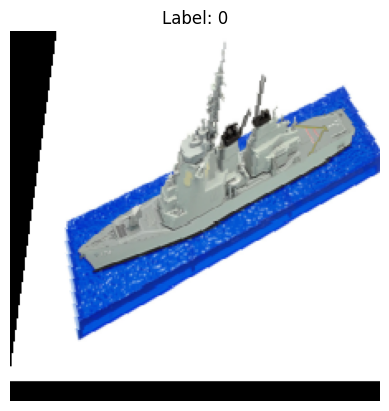

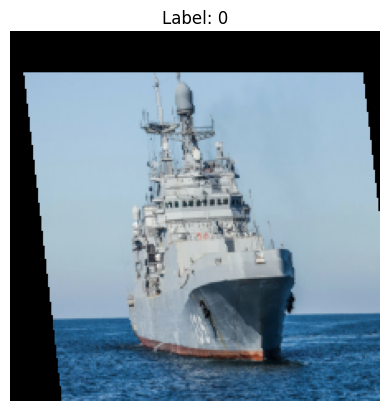

In [ ]:
### START CODE HERE ###
data_loader = load_data("Ship/Ship/Test")
for images, labels in data_loader:
    print(images.shape, labels.shape)
    for i in range(len(images)):
        image = images[i].numpy().transpose(1, 2, 0)
        plt.imshow(image)
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
        plt.show()
        
    break


### END CODE HERE ###

Now, let's create your own `CustomImageDataset` that performs the augmentation as in the previous section, but also includes the methods `add_gaussian_blur()` and `add_gaussian_noise()`. **<font color="red">DO NOT</font>** use `transforms.Compose()`.

Resource : [CustomImageDataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#:~:text=.show()-,Dataset%20class,-torch.utils.data)

In [21]:
### START CODE HERE ###
class CustomImageDataset(Dataset):
    def __init__(self, root_dir):
        self.data = []
        self.labels = []
        self.class_to_idx = {}
        # Walk through the directory and collect image paths and labels
        for idx, class_name in enumerate(sorted(os.listdir(root_dir))):
            class_path = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            self.class_to_idx[class_name] = idx
            for fname in os.listdir(class_path):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.webp')):
                    self.data.append(os.path.join(class_path, fname))
                    self.labels.append(idx)

    def __len__(self):
        return len(self.data)

    def add_gaussian_blur(self, image, ksize=(5, 5)):
        return cv2.GaussianBlur(image, ksize, 0)

    def add_gaussian_noise(self, image, var=0.01):
        noisy = random_noise(image, mode='gaussian', var=var)
        noisy = np.clip(noisy * 255, 0, 255).astype(np.uint8)
        return noisy

    
    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        # Read and convert image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Resize
        image = cv2.resize(image, (224, 224))
        # Pad
        image = cv2.copyMakeBorder(image, 10, 10, 10, 10, cv2.BORDER_REFLECT)
        # Random affine
        rows, cols, ch = image.shape
        angle = random.uniform(-45, 45)
        scale = random.uniform(0.8, 1.2)
        tx = random.uniform(-0.1, 0.1) * cols
        ty = random.uniform(-0.1, 0.1) * rows
        M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, scale)
        M[0, 2] += tx
        M[1, 2] += ty
        image = cv2.warpAffine(image, M, (cols, rows), borderMode=cv2.BORDER_REFLECT)
        # Center crop
        startx = (image.shape[1] - 224) // 2
        starty = (image.shape[0] - 224) // 2
        image = image[starty:starty+224, startx:startx+224]
        # Optionally add blur or noise (uncomment if you want to use)
        # if random.random() < 0.5:
        #     image = self.add_gaussian_blur(image)
        # if random.random() < 0.5:
        #     image = self.add_gaussian_noise(image)
        # Normalize and convert to tensor
        image = image.astype(np.float32) / 255.0
        image = torch.tensor(image).permute(2, 0, 1)  # C, H, W
        label = torch.tensor(label, dtype=torch.long)
        return image, label
### END CODE HERE ###

Use your `CustomImageDataset()` function. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image-2.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/02.png?raw=true)

</details>

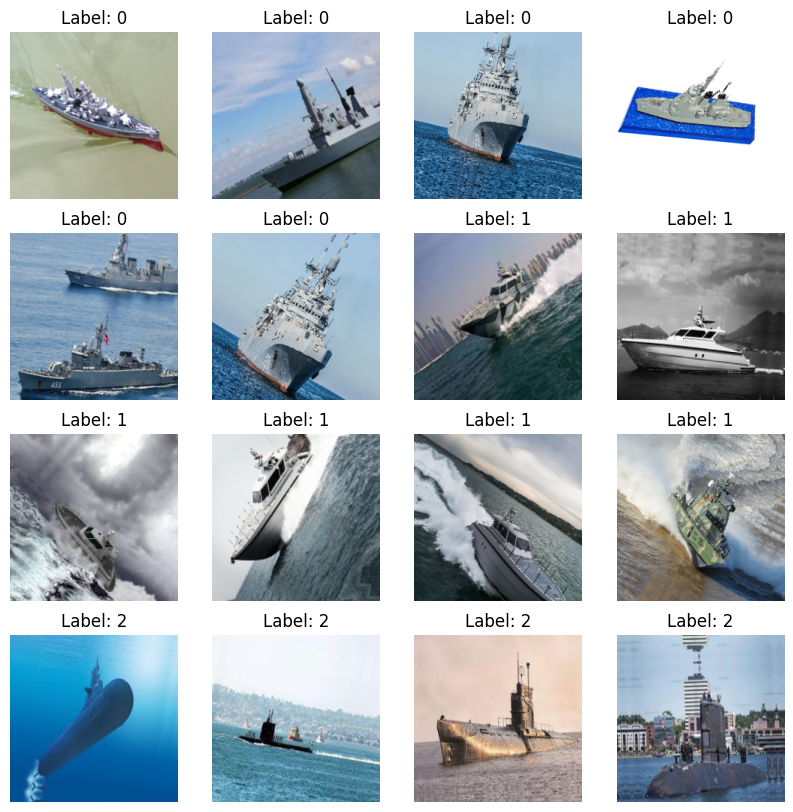

In [24]:
### START CODE HERE ###
dataset = CustomImageDataset("Ship/Ship/Test")
dataloader = DataLoader(dataset)

fig = plt.figure(figsize=(10, 10))
for i, (images, labels) in enumerate(dataloader):
    ax = fig.add_subplot(4, 4, i + 1)
    image = images[0].numpy().transpose(1, 2, 0)
    ax.imshow(image)
    ax.set_title(f"Label: {labels[0].item()}")
    ax.axis('off')
    if i == 15:  # Show only 16 images
        break


### END CODE HERE ###

Questions
1. Discuss effects and benefits of fill_mode or padding_mode.
2. What would be amount of augmentation should be so that it would not effect the training performance?
3. How can we create Salt-and-Pepper Noise, which is the type that greatly affect the image quality?
4. What would be transform parameter to simulate camera lense effect?